In [0]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.getcwd()

'/content'

In [0]:
cd '/content/drive/My Drive/Google_Collab/'

/content/drive/My Drive/Google_Collab


In [0]:
import glob
import pandas as pd
import numpy as np
import re

In [0]:
traint=pd.DataFrame(columns=['path','idd','class_type'])
classs=[]
path=[]
tumor=[]
for p in glob.glob('/content/drive/My Drive/Google_Collab/training/*'):
  if 'True.png' in p:
    classs.append(1)
    tumor.append('tumor')
  else:
    classs.append(0)
    tumor.append('nontumor')
  xf=p.split('/',5)[-1]
  path.append('./'+xf)
traint['path']=path
traint['idd']=classs
traint['class_type']=tumor

In [0]:
print(len(traint))
traint.head()

2125


,path,idd,class_type
0,./training/HG0025-102-True.png,1,tumor
1,./training/HG0025-103-True.png,1,tumor
2,./training/HG0025-106-True.png,1,tumor
3,./training/HG0025-105-True.png,1,tumor
4,./training/HG0025-110-True.png,1,tumor


In [0]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import glob
import cv2
import re
from skimage.io import imshow,imread
from skimage.transform import resize

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import keras
from sklearn.model_selection import train_test_split

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers.core import Dropout, Lambda
from keras.layers import Maximum
from keras.layers import ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU

In [0]:
lb=LabelEncoder()
train_y=lb.fit_transform(traint.idd.values)
train_y=keras.utils.to_categorical(train_y)

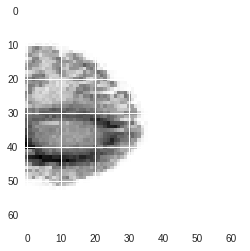

In [0]:
length=len(traint)

In [0]:
import time
from tqdm import tqdm
length=len(traint)

def read_imgs(paths):
  traint=np.zeros((length,64,64,1),dtype=np.uint8)
  for j,p in tqdm(enumerate(paths)):
    img=imread(p)
    img=resize(img,(64,64),mode='constant',preserve_range=True)
    traint[j]=np.expand_dims(img,axis=-1)
  print(traint.shape)
  return traint

In [0]:
train_x = read_imgs(traint['path'].values)

2125it [19:39,  1.71it/s]

(2125, 64, 64, 1)


In [0]:
import h5py

In [0]:
f=h5py.File('/content/drive/My Drive/Google_Collab/train2.h5','w')
f.create_dataset('train_x',data=train_x)
f.create_dataset('train_y',data=train_y)
f.close()

In [0]:
f5=h5py.File('/content/drive/My Drive/Google_Collab/train2.h5','r')
train_x=f5['train_x'][:]
f5.close()
print(train_x.shape)

(2125, 64, 64, 1)


In [0]:
train_x,xvalid,train_y,yvalid=train_test_split(train_x,train_y,shuffle=True,test_size=0.15,random_state=42)


In [0]:
BATCH_SIZE = 32
EPOCHS = 20
RANDOM_STATE = 11


In [0]:
def dense_set(inp_layer, n, activation, drop_rate=0.1):
 
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act



def get_model():
    inp_img = Input(shape=(64, 64, 1))
    s=Lambda(lambda x: x/225)(inp_img)
    # 51
    c1 = Conv2D(16,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(s)
    c1=Dropout(0.1)(c1)
    p1=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(c1)

    c2 = Conv2D(32,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Dropout(0.1)(c2)
    p2=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(c2)

    c3 = Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Dropout(0.1)(c3)
    p3=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(c3)


    flt = Flatten()(p3)
    ds1 = dense_set(flt, 128, activation='elu')
    out = dense_set(ds1, 2, activation='softmax')

    model = Model(inputs=inp_img, outputs=out)
    
    # The first 50 epochs are used by Adam opt.
    # Then 30 epochs are used by SGD opt.
    
    mypotim = Adam()
#     mypotim = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                   optimizer=mypotim,
                   metrics=['accuracy'])
    model.summary()
    return model

In [0]:
filepath='/content/drive/My Drive/Google_Collab/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'

In [0]:
def get_callbacks(filepath, patience=5):
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=patience)
    checkpoints = ModelCheckpoint(filepath, monitor='val_acc',verbose=1,save_best_only=True,mode='max')
    return [lr_reduce, checkpoints]

In [0]:
def train_model(img, target):
    callbacks = get_callbacks(filepath=filepath, patience=6)
    gmodel = get_model()
#     gmodel.load_weights(filepath='model_weight_Adam.hdf5')
    x_train, x_valid, y_train, y_valid = train_test_split(
                                                        img,
                                                        target,
                                                        shuffle=True,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE
                                                        )
    gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True
    )
    gmodel.fit_generator(gen.flow(x_train, y_train,batch_size=BATCH_SIZE),
               steps_per_epoch=10*len(x_train)/BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               shuffle=True,
               validation_data=(x_valid, y_valid),
               callbacks=callbacks)

In [0]:
train_model(train_x,train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
__________

In [0]:
modeltest=get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
__________

In [0]:
modeltest.load_weights('/content/drive/My Drive/Google_Collab/weights-improvement-03-0.69.hdf5')

In [0]:
pred=modeltest.evaluate(xvalid,yvalid)
print(pred)

319/319 [==============================] - 0s 162us/step
[0.5181484448498693, 0.6865203771097906]


In [0]:
print('validation lossL:{}'.format(pred[0]))
print('validation accuracy:{}'.format(pred[1]))

validation lossL:0.5181484448498693
validation accuracy:0.6865203771097906


In [0]:
ENDNDDNDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

In [0]:
actual_value=np.argmax(yvalid,axis=-1)


In [0]:
actual_value.shape

In [0]:
prediction=modeltest.predict(xvalid)

In [0]:
predicted_classes=np.argmax(np.round(prediction),axis=1)

flatten always returns a copy.
ravel returns a view of the original array whenever possible. This isn't visible in the printed output, but if you modify the array returned by ravel, it may modify the entries in the original array. If you modify the entries in an array returned from flatten this will never happen. ravel will often be faster since no memory is copied, but you have to be more careful about modifying the array it returns.

In [0]:
predicted=predicted_classes.ravel()

In [0]:
predicted.shape

(475,)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
print(classification_report(actual_value,predicted))

             precision    recall  f1-score   support

          0       0.69      0.56      0.62        16
          1       0.98      1.00      0.99        51
          2       0.97      0.89      0.93        36
          3       1.00      0.80      0.89        59
          4       0.91      0.95      0.93        22
          5       1.00      0.92      0.96        52
          6       0.91      1.00      0.95        60
          7       0.96      1.00      0.98        24
          8       0.96      0.98      0.97        56
          9       0.71      0.89      0.79        19
         10       0.86      1.00      0.92        48
         11       1.00      0.97      0.98        32

avg / total       0.94      0.93      0.93       475



In [0]:
cm=confusion_matrix(actual_value,predicted)

In [0]:
import seaborn as sns

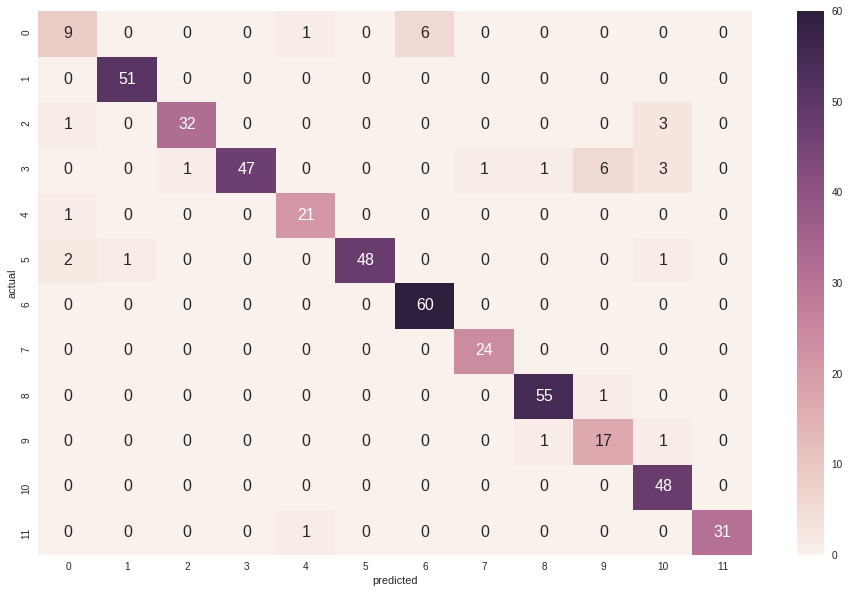

In [0]:
sns.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.figure()